In [1]:
using Plots
using LinearAlgebra
using Revise
using NeuralVerification
using NeuralVerification:Network, Layer, ReLU, Id, read_nnet, compute_output
using LazySets

┌ Info: Precompiling NeuralVerification [146f25fa-00e7-11e9-3ae5-fdbac6e12fa7]
└ @ Base loading.jl:1278
┌ Warning: Package NeuralVerification does not have CPLEX in its dependencies:
│ - If you have NeuralVerification checked out for development and have
│   added CPLEX as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with NeuralVerification
└ Loading CPLEX into NeuralVerification from project dependency, future warnings for NeuralVerification are suppressed.


In [5]:
include("unicycle_env.jl")
include("problem.jl")
include("controller.jl")
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"

"../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"

In [9]:
function get_rp(net_path)
    obj_cost = [1000,1000,0.001,0.001]
    x0 = [1,0,0,π/2]
    xg = [1,4,0,π/2]
    net = read_nnet(net_path)
    curve_rp = ReachingProblem(net, obj_cost, x0, xg);
    return curve_rp
end
rp = get_rp(net_path);
function get_Xref(x0, xg, T, dt)
    tf = T*dt
    dp = [xg[1]-x0[1], xg[2]-x0[2]]
    v = norm(dp)/tf
    Xref = [[x0[1]+k*dp[1]/T, x0[2]+k*dp[2]/T, v, xg[4]] for k = 1:T]
    Xref[end][3] = 0
    return Xref
end

get_Xref (generic function with 1 method)

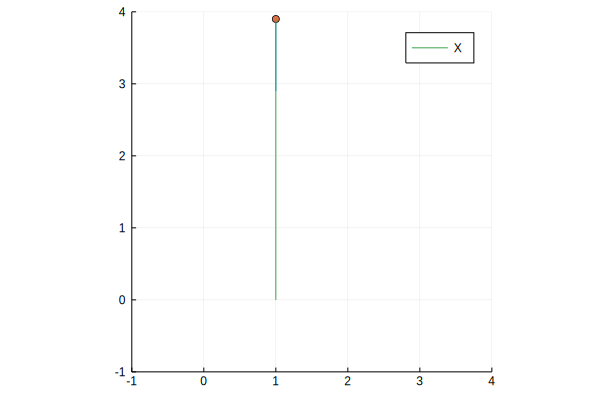

In [7]:
visualize(straight_tp.Xref)

In [ ]:
function phi_safe_set(x, obs, dt)
    p = phi(x, obs)
    C = grad_phi(x, obs)
    d = p < 0 ? -p/dt : -p/dt*4
    return HalfSpace(C, d)
end

function linear_cost(x, xref, obj_cost)
    sum(abs.(x_cand - xref).*obj_cost)
end


function tracking(rp::ReachingProblem, ctrl; T=20, dt=0.1, obstacle=nothing)
    x = rp.x0
    X = [copy(rp.x0) for k = 1:T]
    U = [zeros(2) for k = 1:T-1]
    safe_sets = []
    tot_time = 0
    for i in 1:T-1
        dx = (rp.xg - x)
        k = norm(dx) * dt
        if norm(dx) < 1
            k = dt
        end
        xref = x + dx/norm(dx)*dt
        
        Xref = get_Xref(rp.x0, rp.xg, T-i, dt)
        
        timed_result = @timed get_control(ctrl, xref, x, rp.net, rp.obj_cost, dt, obstacle=obstacle)
        u, safe_set = timed_result.value
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        x = forward(net, x, u, dt)
        X[i+1] = x
        U[i] = u
        
#         p = phi(x, obstacle)
#         grad_p = grad_phi(x, obstacle)
#         dot_x = compute_output(rp.net, [x;u])
#         dot_p = grad_p'dot_x
        
#         @show rp.xg-x
#         @show p
#         @show grad_p
#         @show dot_x
#         @show dot_p
        
    end
    return X, U, safe_sets
end



Xref = get_Xref(x, rp.xg, tf-t, dt)